In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  786M    0 2850k    0     0  2850k      0  0:04:42 --:--:--  0:04:42 5877k
  2  786M    2 21.0M    0     0  21.0M      0  0:00:37  0:00:01  0:00:36 14.1M
  7  786M    7 60.9M    0     0  30.4M      0  0:00:25  0:00:02  0:00:23 24.5M
 12  786M   12 97.6M    0     0  32.5M      0  0:00:24  0:00:03  0:00:21 28.0M
 17  786M   17  134M    0     0  33.6M      0  0:00:23  0:00:04  0:00:19 29.9M
 21  786M   21  171M    0     0  34.2M      0  0:00:22  0:00:05  0:00:17 33.6M
 26  786M   26  208M    0     0  34.6M      0  0:00:22  0:00:06  0:00:16 37.3M
 31  786M   31  244M    0     0  34.9M      0  0:00:22  0:00:07  0:00:15 36.7M
 35  786M   35  281M    0     0  35.1M      0  0:00:22  0:00:08  0:00:14 36.7M
 40  786M   40  317M    0     0  35.3M      0  0:00

## Filter out corrupted images

import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("Z:\MIT FutureMakers\Week 3\kagglecatsanddogs_3367a/PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

## Generate a Dataset

In [15]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Z:\MIT FutureMakers\Week 3\kagglecatsanddogs_3367a/PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Z:\MIT FutureMakers\Week 3\kagglecatsanddogs_3367a\PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


## Visualizing the Data

#### Labels

* 1 = Dog
* 0 = Cat

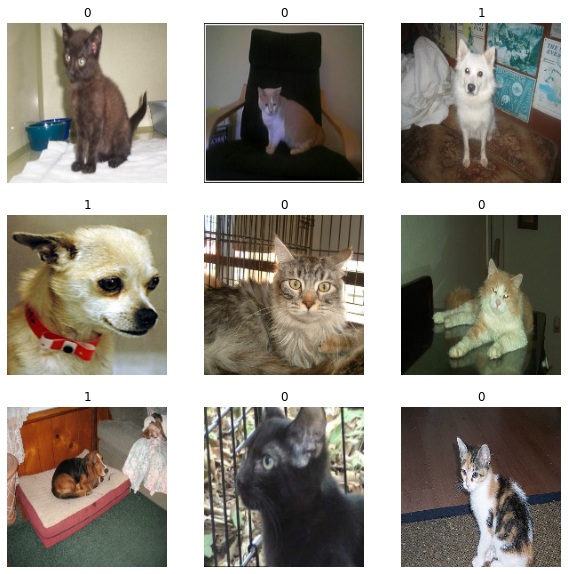

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Image Augmentation

* Applying realistic transformations such as rotations or flipping to improve the sample diversity and reduce the likelihood of overfitting

In [17]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

* Let's visualize the augmented sample by repeatedly applying data_augmentation to the first image in the dataset

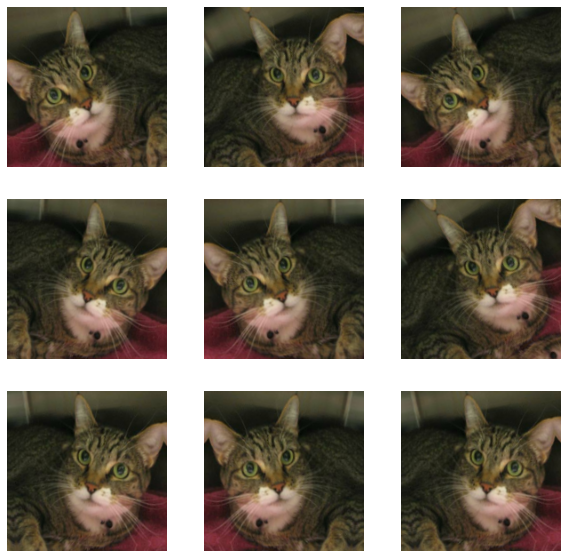

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Standardizing the Data

* Goal: Standardize the RGB channels in the images to [0, 1] 
* This is achieved using the data_augmentation preprocessor
* Note that the code for this step is integrated into the model itself at the beginning

## Configure the dataset for performance

In [23]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Build a Model

* Note the presence of the dropout layer before the final classification layer

In [24]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## Training the Model

In [25]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
586/586 [==============================] - 1285s 2s/step - loss: 0.6315 - accuracy: 0.6540 - val_loss: 0.5498 - val_accuracy: 0.7193
Epoch 2/50


c:\users\jackt\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


586/586 [==============================] - 1263s 2s/step - loss: 0.4838 - accuracy: 0.7721 - val_loss: 0.6274 - val_accuracy: 0.7361
Epoch 3/50
586/586 [==============================] - 1219s 2s/step - loss: 0.3941 - accuracy: 0.8245 - val_loss: 0.3597 - val_accuracy: 0.8409
Epoch 4/50
586/586 [==============================] - 1217s 2s/step - loss: 0.3292 - accuracy: 0.8589 - val_loss: 0.6379 - val_accuracy: 0.7733
Epoch 5/50
586/586 [==============================] - 1218s 2s/step - loss: 0.2745 - accuracy: 0.8841 - val_loss: 0.2587 - val_accuracy: 0.8890
Epoch 6/50
586/586 [==============================] - 1220s 2s/step - loss: 0.2428 - accuracy: 0.8977 - val_loss: 0.7695 - val_accuracy: 0.7237
Epoch 7/50
586/586 [==============================] - 1240s 2s/step - loss: 0.2192 - accuracy: 0.9084 - val_loss: 0.4137 - val_accuracy: 0.8339
Epoch 8/50
586/586 [==============================] - 1254s 2s/step - loss: 0.1955 - accuracy: 0.9160 - val_loss: 0.2888 - val_accuracy: 0.8858
Epo

## Running Inference on the Data

In [28]:
img = keras.preprocessing.image.load_img(
    "Z:\MIT FutureMakers\Week 3\kagglecatsanddogs_3367a/PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 8.70 percent cat and 91.30 percent dog.
